In [ ]:
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import os


# ================== Configure Logging ==================
# logging.basicConfig(level=logging.DEBUG, format='%(levelname)s:%(message)s')
logger = logging.getLogger()

# ================== Utility Functions ==================
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))  # Stability improvement
    return e_x / e_x.sum()

def gini(x):
    """Robust Gini Coefficient Calculation"""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0.0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx)/cumx[-1])/n

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def jain_fairness(x):
    """Improved Jain Index Calculation"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x)**2) / (len(x)*np.sum(x**2) + 1e-8) * sigmoid(np.mean(x)/10)

# ================== Node Class ==================
class Node:
    """Enhanced Federated Learning Node"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake
        self.reputation = init_rep
        self.total_reward = 0
        self.violations = 0
        self.participation = 0
        self.contrib_history = []
        self.cooldown = 0
        self.last_violation_round = -np.inf
        self.consecutive_committee = 0
        self.total_committee = 0
        self.identity_verified = True  # All nodes are verified

    def update_committee_status(self, is_in_committee):
        """Update committee status (including cooldown mechanism)"""
        if is_in_committee and self.cooldown <= 0:
            self.consecutive_committee += 1
            self.total_committee += 1
            self.cooldown = 3  # Example cooldown period
            logger.debug(f"Node {self.id} selected for committee. Cooldown set to {self.cooldown}.")
        else:
            if is_in_committee and self.cooldown > 0:
                logger.debug(f"Node {self.id} attempted to join committee but is in cooldown.")
            self.consecutive_committee = 0
        # Decrement cooldown if greater than 0
        if self.cooldown > 0:
            self.cooldown = max(0, self.cooldown - 1)
            logger.debug(f"Node {self.id} cooldown decremented to {self.cooldown}.")

    def act_normal(self):
        """Normal behavior pattern (with random fluctuation)"""
        base = np.random.normal(7, 1)
        fluctuation = np.random.choice([0.8, 1.0, 1.2], p=[0.2, 0.6, 0.2])
        contrib = max(0, base * fluctuation)
        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted normally with contribution {contrib:.2f}.")
        return contrib

    def act_malicious(self, phase):
        """Enhanced robust malicious behavior method"""
        try:
            phase = int(phase)
            if phase == 1:  # High contribution attack
                contrib = max(9.5, np.random.normal(9.8, 0.3))
            elif phase == 2:    # Zero contribution attack
                contrib = 0
            elif phase == 3:    # Random attack (60% high contrib, 40% zero)
                contrib = np.random.choice([10, 0], p=[0.6, 0.4])
            else:
                raise ValueError(f"Invalid attack phase: {phase}")
        except Exception as e:
            logger.error(f"Node {self.id} attack phase error: {str(e)}")
            contrib = 0  # Safe default value

        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted maliciously with contribution {contrib}.")
        return contrib

# ================== FLSystem Class ==================
class FLSystem:
    """Federated Learning System Simulator (Optimized for Stratified Sampling)"""
    def __init__(self, 
                 num_nodes=100,
                 base_reward=1000,
                 committee_size=10,
                 stake_weight=0.4,
                 rep_exponent=0.5,
                 init_stake=100,
                 init_rep=100,
                 malicious_ratio=0.1,
                 phase_switch_round=25,
                 sybil_resistance=False):  # Sybil resistance not needed
        # Save parameters as instance attributes
        self.sybil_resistance = sybil_resistance  # Not used in selection
        
        # Initialize nodes
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        
        # Initialize malicious nodes
        self.malicious_nodes = self._init_malicious_nodes(malicious_ratio)
        
        # System parameters
        self.base_reward = base_reward
        self.malicious_ratio = malicious_ratio
        self.committee_size = committee_size
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.phase_switch_round = phase_switch_round
        
        # Tracking state
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []
        self.gini_history = []
        self.fairness_history = []
        self.detection_history = []
        self.committee_history = []  # Committee history
        self.penalty_history = []  # Penalty history

    def _init_malicious_nodes(self, ratio):
        """Initialize malicious nodes (all nodes are verified)"""
        num_malicious = int(len(self.nodes) * ratio)
        malicious = self.nodes[:num_malicious]
        logger.info(f"Initialized {num_malicious} malicious nodes.")
        return malicious  # All malicious nodes are verified

    def _dynamic_malicious_threshold(self):
        """Dynamically calculate the threshold for malicious node detection"""
        # Get the latest contribution values of all nodes
        contribs = []
        for n in self.nodes:
            if n.contrib_history:
                contribs.append(n.contrib_history[-1])
            else:
                contribs.append(0)
        
        # Calculate the 30th percentile and adjust
        percentile_30 = np.percentile(contribs, 30)
        threshold = percentile_30 * 0.7 + 1e-8  # Add a tiny value to prevent division by zero
        logger.debug(f"Dynamic malicious threshold calculated: {threshold:.4f}")
        return threshold

    def select_committee(self, num_strata=3):
        """
        Select committee members using stratified sampling based on reputation and cooldown.

        Parameters:
            num_strata (int): Number of strata to divide the nodes into.

        Returns:
            selected (list): List of selected committee nodes.
        """
        # Sort nodes by reputation descending
        sorted_nodes = sorted(self.nodes, key=lambda x: x.reputation, reverse=True)
        strata_size = len(sorted_nodes) // num_strata
        strata = [sorted_nodes[i*strata_size : (i+1)*strata_size] for i in range(num_strata)]
        
        # Handle any remaining nodes by adding to the last stratum
        if len(sorted_nodes) % num_strata != 0:
            strata[-1].extend(sorted_nodes[num_strata*strata_size:])
            logger.debug(f"Added {len(sorted_nodes) % num_strata} nodes to the last stratum.")

        selected = []
        quotas = [self.committee_size // num_strata] * num_strata  # Initial quota per stratum
        remaining_quota = self.committee_size - sum(quotas)

        # Distribute remaining_quota among the first few strata
        for i in range(remaining_quota):
            quotas[i % num_strata] += 1
        logger.debug(f"Final Quotas per Stratum: {quotas}")

        # First Pass: Select based on strata quotas
        for idx, (stratum, quota) in enumerate(zip(strata, quotas)):
            # Filter eligible candidates (not in cooldown)
            candidates = [node for node in stratum if node.cooldown <= 0]
            eligible_count = len(candidates)
            logger.debug(f"Stratum {idx+1}: {eligible_count} eligible candidates.")

            if eligible_count == 0:
                logger.debug(f"Stratum {idx+1} has no eligible candidates. Quota remains unfilled.")
                continue  # Quota will be redistributed later

            # Determine how many to select from this stratum
            select_count = min(quota, eligible_count)
            select_count = max(1, select_count)  # Ensure at least one selection if possible

            # Calculate selection probabilities based on reputation
            if eligible_count == 1:
                probabilities = [1.0]
            else:
                reputation_scores = np.array([node.reputation for node in candidates], dtype=float)
                probabilities = softmax(reputation_scores ** self.rep_exponent)
            
            # Select nodes
            selected_nodes = np.random.choice(candidates, size=select_count, p=probabilities, replace=False)
            selected.extend(selected_nodes)
            logger.debug(f"Stratum {idx+1}: Selected {select_count} nodes.")

        # Check if committee size is met
        if len(selected) < self.committee_size:
            logger.debug(f"Committee size after first pass: {len(selected)}. Redistributing remaining quota.")
            remaining_quota = self.committee_size - len(selected)
            
            # Gather all eligible nodes not yet selected
            eligible_nodes = [node for node in self.nodes if node.cooldown <= 0 and node not in selected]
            eligible_count = len(eligible_nodes)
            logger.debug(f"Total eligible nodes for redistribution: {eligible_count}.")

            if eligible_count >= remaining_quota:
                if eligible_count == 1:
                    probabilities = [1.0]
                else:
                    reputation_scores = np.array([node.reputation for node in eligible_nodes], dtype=float)
                    probabilities = softmax(reputation_scores ** self.rep_exponent)
                
                # Select remaining_quota nodes
                selected_nodes = np.random.choice(eligible_nodes, size=remaining_quota, p=probabilities, replace=False)
                selected.extend(selected_nodes)
                logger.debug(f"Redistributed and selected {remaining_quota} additional nodes.")
            elif eligible_count > 0:
                # Select all remaining eligible nodes
                selected.extend(eligible_nodes)
                logger.warning(f"Only {eligible_count} eligible nodes available for redistribution. Committee size reduced.")
        
        # Final Check
        if len(selected) < self.committee_size:
            logger.warning(f"Unable to fill the committee to the desired size of {self.committee_size}. "
                           f"Only {len(selected)} members selected.")
        else:
            logger.debug(f"Successfully selected {len(selected)} committee members.")
        
        # Update node statuses
        for node in self.nodes:
            node.update_committee_status(node in selected)
        
        self.committee_history.append([node.id for node in selected])
        logger.info(f"Round {self.current_round + 1}: Committee selected with {len(selected)} members.")
        
        return selected

    def calculate_reward(self, node, avg_rep):
        """Dynamic hybrid reward calculation"""
        # Effective stake (anti-monopoly)
        avg_stake = np.mean([n.stake for n in self.nodes])
        effective_stake = min(node.stake, avg_stake * 3)
        
        # Time-decayed contribution
        hist_contrib = sum(c * (0.9**t) for t, c in enumerate(reversed(node.contrib_history[-5:])))
        
        # Normalize using total time-decayed contributions of all nodes
        total_hist_contrib = sum(
            sum(c * (0.9**t) for t, c in enumerate(reversed(n.contrib_history[-5:])))
            for n in self.nodes
        )
        total_hist_contrib = total_hist_contrib if total_hist_contrib > 0 else 1e-8  # Prevent division by zero
        
        # Dynamic weights using sigmoid function
        alpha = sigmoid((avg_rep - 100)/50) * self.stake_weight
        beta = 1 - alpha
        
        # Diversity bonus
        diversity_bonus = 1 - gini([n.reputation for n in self.nodes])
        
        # Committee reward
        committee_reward = 40 * diversity_bonus if node.id in self.committee_history[-1] else 0
        
        # Total reward calculation
        total = (alpha * self.base_reward * (effective_stake / (sum(n.stake for n in self.nodes) + 1e-8)) +
                beta * self.base_reward * (hist_contrib / total_hist_contrib)) * diversity_bonus + committee_reward
        
        return max(total, 0)

    def update_reputation(self, node, contribution):
        """Robust reputation update system"""
        # Dynamic decay
        age_factor = 1 - 1/(1 + node.participation/100)
        delta = 0.88 + 0.07 * age_factor
        
        # Contribution quality
        contrib_quality = sigmoid((contribution - 5)/3)
        
        # Stability evaluation
        if len(node.contrib_history) >= 5:
            stability = 1 - np.std(node.contrib_history[-5:])/5
        else:
            stability = 0.8
            
        new_rep = (node.reputation * delta +
                  contrib_quality * 50 +
                  stability * 30)
        
        # Dynamic cap
        rep_cap = 500 if self.current_round > 50 else 300
        return np.clip(new_rep, 0, rep_cap)

    def detect_malicious(self, node):
        """Hybrid detection strategy"""
        # Basic detection
        if len(node.contrib_history) < 5:
            return False
        
        window = node.contrib_history[-5:]
        avg = np.mean(window)
        std = np.std(window)
        threshold = self._dynamic_malicious_threshold()
        
        # Rule 1: Persistent low contributions
        condition1 = avg < threshold * 0.7
        
        # Rule 2: Abnormal fluctuation
        condition2 = std < threshold * 0.4
        
        # Rule 3: Sudden behavior change
        if len(node.contrib_history) >= 10:
            prev_avg = np.mean(node.contrib_history[-10:-5])
        else:
            prev_avg = 7  # Default value if not enough history
        condition3 = abs(avg - prev_avg) > 5
        
        is_malicious = (condition1 and condition2) or condition3
        logger.debug(f"Node {node.id} detection: Condition1={condition1}, Condition2={condition2}, Condition3={condition3} -> {is_malicious}")
        return is_malicious

    def run_round(self):
        """Execute simulation round"""        
        # Improved phase calculation logic
        base_phase = 1 if self.current_round < self.phase_switch_round else 2
        phase_variation = int(self.current_round/30) % 2
        attack_phase = min(base_phase + phase_variation, 3)
        logger.info(f"Round {self.current_round + 1}: Phase {attack_phase}")
        
        contributions = []  # Initialize contributions list
        
        # Collect all nodes' contributions
        for node in self.nodes:
            if node in self.malicious_nodes:
                contrib = node.act_malicious(attack_phase)
            else:
                contrib = node.act_normal()
            contributions.append(contrib)  # Add this line

        # Committee selection
        self.committee = self.select_committee()
        
        # System updates
        avg_rep = np.mean([n.reputation for n in self.nodes])
        rewards = []
        detected = 0
        penalties = []
        
        for node, contrib in zip(self.nodes, contributions):
            # Detection and penalty
            if self.detect_malicious(node):
                penalty = min(0.3 * node.reputation + 0.1 * node.stake, node.reputation*0.5)
                penalties.append(penalty)
                node.reputation -= penalty
                node.violations += 1
                detected += 1
                logger.debug(f"Node {node.id} detected as malicious. Penalty applied: {penalty:.2f}")
            else:
                node.reputation = self.update_reputation(node, contrib)
                logger.debug(f"Node {node.id} reputation updated to {node.reputation:.2f}")
            
            # Reward calculation
            reward = self.calculate_reward(node, avg_rep)
            node.total_reward += reward
            rewards.append(reward)
            logger.debug(f"Node {node.id} received reward: {reward:.2f} | Total Reward: {node.total_reward:.2f}")
            
            node.participation += 1

        # Record metrics
        self.penalty_history.append(penalties)
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.gini_history.append(gini(rewards))
        self.fairness_history.append(jain_fairness(rewards))
        self.detection_history.append(detected)
        self.current_round += 1
        logger.info(f"Round {self.current_round}: Detected {detected} malicious nodes.")

# ================== Visualization Module ==================
def plot_metrics(system, label="System"):
    """System-Wide Metrics Visualization"""
    
    plt.figure(figsize=(18, 12))

    # ---------- Fairness metrics -------------
    plt.subplot(2, 2, 1)
    rewards = np.array(system.reward_history)
    rounds = np.arange(rewards.shape[0])
    num_nodes = rewards.shape[1]

    plt.plot(system.gini_history, linewidth=3, label='Gini Coefficient')
    plt.plot(system.fairness_history, linewidth=3, label="Jain's Fairness Index")
    plt.axhline(0.3, color='green', linestyle='--', label='Healthy Gini Threshold')
    plt.axhline(1, color='red', linestyle='--', label='Ideal Fairness Threshold')
    plt.title(f'{label} - Fairness Metrics Dynamics\nTotal Nodes: {num_nodes} | Rounds: {len(rounds)}', 
             fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()
    plt.tight_layout()
    
    # --------- Reputation Distribution -----------
    plt.subplot(2, 2, 2)
    if not system.reputation_history:
        print("警告：无声誉数据可供可视化")
        plt.title('声誉数据未找到')
        return
    
    reps = np.array(system.reputation_history)
    rounds = np.arange(reps.shape[0])
    num_nodes = reps.shape[1]
    
    # Identify malicious nodes
    malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
    honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
    
    # Plot individual traces with group coloring
    for node_id in range(num_nodes):
        color = 'tomato' if node_id in malicious_ids else 'skyblue'
        alpha = 0.2 if node_id in malicious_ids else 0.1
        plt.plot(rounds, reps[:, node_id], 
                color=color, 
                alpha=alpha, 
                linewidth=0.8,
                zorder=1)
    
    # Calculate group averages
    if malicious_ids:
        malicious_avg = np.mean(reps[:, malicious_ids], axis=1)
        malicious_q1 = np.percentile(reps[:, malicious_ids], 25, axis=1)
        malicious_q3 = np.percentile(reps[:, malicious_ids], 95, axis=1)
    else:
        malicious_avg = np.array([])
        malicious_q1 = np.array([])
        malicious_q3 = np.array([])
    
    honest_avg = np.mean(reps[:, honest_ids], axis=1)
    honest_q1 = np.percentile(reps[:, honest_ids], 25, axis=1)
    honest_q3 = np.percentile(reps[:, honest_ids], 95, axis=1)
    
    # Plot group averages
    plt.plot(rounds, honest_avg, 
            color='dodgerblue', 
            linewidth=3, 
            linestyle='-',
            label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
            zorder=4)
    
    if len(malicious_avg) > 0:
        plt.plot(rounds, malicious_avg, 
                color='crimson', 
                linewidth=3, 
                linestyle='--',
                label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                zorder=5)

    # Plot group statistics
    plt.fill_between(rounds, honest_q1, honest_q3,
                    color='skyblue', alpha=0.3,
                    label='Honest IQR', zorder=2)
    plt.plot(rounds, honest_avg,
            color='dodgerblue', lw=3,
            label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
    
    # Plot malicious nodes statistics (if any)
    if len(malicious_avg) > 0:
        plt.fill_between(rounds, malicious_q1, malicious_q3,
                        color='lightcoral', alpha=0.3,
                        label='Malicious IQR', zorder=2)
        plt.plot(rounds, malicious_avg,
                color='crimson', lw=3, linestyle='--',
                label=f'[{len(malicious_ids)}] Malicious Avg (Final: {malicious_avg[-1]:.1f})')
    
    # Formatting
    plt.title(f'{label} - Reputation Distribution Dynamics\n'
             f'Total Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}', 
             fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Reputation Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Create layered legend
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
        Line2D([0], [0], color='dodgerblue', lw=2, label=f'[{len(honest_ids)}] Honest Average'),
    ]
    
    if len(malicious_avg) > 0:
        legend_elements.extend([
            Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
            Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'[{len(malicious_ids)}] Malicious Average'),
        ])
    
    legend_elements.extend([
        Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
    ])
    
    if len(malicious_avg) > 0:
        legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
    
    plt.legend(handles=legend_elements, 
              loc='upper center',
              bbox_to_anchor=(0.2, 0.35),  
              ncol=1,
              frameon=False,
              fontsize=10)
    
    # Add dynamic statistical annotations
    stats_text = []
    if len(malicious_avg) > 0:
        stats_text.append(f"Malicious Reputation Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
    stats_text.extend([
        f"Honest Reputation Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
        f"Final Reputation Range: {np.min(reps[-1]):.1f}-{np.max(reps[-1]):.1f}",
    ])
    
    plt.annotate('\n'.join(stats_text), 
                xy=(0.95, 0.6),
                xycoords='axes fraction',
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))

    
    # -------- Security Detection ------------
    plt.subplot(2, 2, 3)
    if malicious_ids:
        plt.bar(range(len(system.detection_history)), system.detection_history, alpha=0.6, color='crimson')
        plt.title(f'{label} - Malicious Node Detection\n'
                  f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
                  fontsize=14, pad=20)
        plt.xlabel('Round', fontsize=12)
        plt.ylabel('Total Detected', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
    
    # -------- Reward Distribution ------------
    plt.subplot(2, 2, 4)
    """Dynamic reward distribution visualization (including malicious/honest node distinction)"""
    if not system.reward_history:
        print("警告：无奖励数据可供可视化")
        plt.title('奖励数据未找到')
        return
    # Data preparation
    rewards = np.array(system.reward_history)
    rounds = np.arange(rewards.shape[0])
    num_nodes = rewards.shape[1]
    
    # Identify malicious nodes
    malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
    honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
    
    # Plot individual reward traces with group coloring
    for node_id in range(num_nodes):
        color = 'tomato' if node_id in malicious_ids else 'skyblue'
        alpha = 0.15 if node_id in malicious_ids else 0.08
        plt.plot(rounds, rewards[:, node_id], 
                color=color, 
                alpha=alpha, 
                linewidth=0.6,
                zorder=1)
    
    # Calculate group statistics
    if malicious_ids:
        malicious_avg = np.mean(rewards[:, malicious_ids], axis=1)
        malicious_q1 = np.percentile(rewards[:, malicious_ids], 25, axis=1)
        malicious_q3 = np.percentile(rewards[:, malicious_ids], 95, axis=1)
    else:
        malicious_avg = np.array([])
        malicious_q1 = np.array([])
        malicious_q3 = np.array([])
    
    honest_avg = np.mean(rewards[:, honest_ids], axis=1)
    honest_q1 = np.percentile(rewards[:, honest_ids], 25, axis=1)
    honest_q3 = np.percentile(rewards[:, honest_ids], 95, axis=1)
    
    # Plot group averages
    plt.plot(rounds, honest_avg, 
            color='dodgerblue', 
            linewidth=3, 
            linestyle='-',
            label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
            zorder=4)
    
    if len(malicious_avg) > 0:
        plt.plot(rounds, malicious_avg, 
                color='crimson', 
                linewidth=3, 
                linestyle='--',
                label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                zorder=5)

    # Plot group statistics
    plt.fill_between(rounds, honest_q1, honest_q3,
                    color='skyblue', alpha=0.3,
                    label='Honest IQR')
    plt.plot(rounds, honest_avg,
            color='dodgerblue', lw=3,
            label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
    
    # Plot malicious nodes statistics (if any)
    if len(malicious_avg) > 0:
        plt.fill_between(rounds, malicious_q1, malicious_q3,
                        color='lightcoral', alpha=0.3,
                        label='Malicious IQR')
        plt.plot(rounds, malicious_avg,
                color='crimson', lw=3, linestyle='--',
                label=f'[{len(malicious_ids)}] Malicious Avg (Final: {malicious_avg[-1]:.1f})')
    
    # Formatting
    plt.title(f'{label} - Reward Distribution Dynamics\n'
             f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
             fontsize=14, pad=20)
    plt.xlabel('Training Rounds', fontsize=12)
    plt.ylabel('Reward Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Create layered legend
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
        Line2D([0], [0], color='dodgerblue', lw=2, label=f'[{len(honest_ids)}] Honest Average'),
    ]
    
    if len(malicious_avg) > 0:
        legend_elements.extend([
            Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
            Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'[{len(malicious_ids)}] Malicious Average'),
        ])
    
    legend_elements.extend([
        Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
    ])
    
    if len(malicious_avg) > 0:
        legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
    
    plt.legend(handles=legend_elements,
              loc='upper center',
              bbox_to_anchor=(0.2, 0.35),
              ncol=1,
              frameon=False,
              fontsize=10)
    
    # Add dynamic statistical annotations
    stats_text = []
    if len(malicious_avg) > 0:
        stats_text.append(f"Malicious Reward Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
    stats_text.extend([
        f"Honest Reward Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
        f"Final Reward Range: {np.min(rewards[-1]):.1f}-{np.max(rewards[-1]):.1f}",
    ])
    
    plt.annotate('\n'.join(stats_text), 
                xy=(0.95, 0.8),
                xycoords='axes fraction',
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))
    
    plt.tight_layout()
    plt.show()

# =================== Simulation Report =====================
def generate_simulation_report(system, filename):
    """
    Generates simulation reports for an FLSystem instance and saves them as CSV files.

    Parameters:
        system (FLSystem): The federated learning system instance containing simulation data.
        filename (str): The base filename for the generated reports. The function will create
                        two CSV files with suffixes '_round_metrics.csv' and '_node_summary.csv'.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
               (round_metrics_df, node_summary_df)
    """
    # Validate the filename extension
    if not filename.lower().endswith('.csv'):
        raise ValueError("Filename must end with '.csv'")
    
    # Derive base name without extension
    base, ext = os.path.splitext(filename)
    
    # Define filenames for round metrics and node summary
    round_metrics_filename = f"{base}_round_metrics.csv"
    node_summary_filename = f"{base}_node_summary.csv"
    
    # ------------------ Extract Per-Round Metrics ------------------
    rounds = list(range(1, system.current_round + 1))
    gini_vals = system.gini_history
    fairness = system.fairness_history
    detected = system.detection_history
    penalties = system.penalty_history  # List of lists
    committee_history = system.committee_history  # List of lists
    
    # Calculate total penalties per round
    total_penalties = [sum(penalty_round) for penalty_round in penalties]
    
    # Format committee members as comma-separated strings
    committee_members = [', '.join(map(str, committee)) for committee in committee_history]
    
    # Create a DataFrame for per-round metrics
    round_metrics_df = pd.DataFrame({
        'Round': rounds,
        'Gini Coefficient': gini_vals,
        'Fairness Index': fairness,
        'Detected Malicious Nodes': detected,
        'Total Penalties': total_penalties,
        'Committee Members': committee_members
    })
    
    # ------------------ Extract Per-Node Summary Metrics ------------------
    node_ids = [node.id for node in system.nodes]
    stakes = [node.stake for node in system.nodes]
    final_reputations = [node.reputation for node in system.nodes]
    total_rewards = [node.total_reward for node in system.nodes]
    violations = [node.violations for node in system.nodes]
    participation = [node.participation for node in system.nodes]
    total_committee = [node.total_committee for node in system.nodes]
    cooldowns = [node.cooldown for node in system.nodes]
    
    # Create a DataFrame for per-node summary
    node_summary_df = pd.DataFrame({
        'Node ID': node_ids,
        'Stake': stakes,
        'Final Reputation': final_reputations,
        'Total Reward': total_rewards,
        'Violations': violations,
        'Participation Count': participation,
        'Total Committee Memberships': total_committee,
        'Current Cooldown': cooldowns
    })
    
    # ------------------ Save DataFrames to CSV Files ------------------
    try:
        # Save round metrics
        round_metrics_df.to_csv(round_metrics_filename, index=False)
        print(f"Round metrics saved to {round_metrics_filename}")
        
        # Save node summary
        node_summary_df.to_csv(node_summary_filename, index=False)
        print(f"Node summary metrics saved to {node_summary_filename}")
        
    except Exception as e:
        print(f"Error saving simulation reports: {e}")
        raise e
    
    # ------------------ Return DataFrames ------------------
    return round_metrics_df, node_summary_df

# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        "with_malicious_0p10": FLSystem(
            num_nodes=100,
            base_reward=1000,
            committee_size=10,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.1,  # 10% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p15": FLSystem(
            num_nodes=100,
            base_reward=1000,
            committee_size=10,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p20": FLSystem(
            num_nodes=100,
            base_reward=1000,
            committee_size=10,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.2,  # 20% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p25": FLSystem(
            num_nodes=100,
            base_reward=1000,
            committee_size=10,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.25,  # 25% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p30": FLSystem(
            num_nodes=100,
            base_reward=1000,
            committee_size=10,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.3,  # 30% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False  # Sybil resistance not considered
        ),
        "without_malicious": FLSystem(
            num_nodes=100,
            base_reward=1000,
            committee_size=10,
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.0,  # No malicious nodes
            phase_switch_round=30,
            sybil_resistance=False
        )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = 80
    rounds_without_malicious = 80

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    print("\n开始运行不包含恶意节点的模拟...")
    for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
        systems["without_malicious"].run_round()
    
    # Generate Reports
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"simulation_report_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=10):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=10)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        # if "with_malicious" in key:
        #     print(key.split('_')[-1][1:])
        #     # malicious_ratio_str = key.split('_')[-1][1:]
        #     # malicious_ratio = float(malicious_ratio_str) / 100
        #     # label += f" ({int(malicious_ratio * 100)}% Malicious)"
        # else:
        #     label += ""
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


开始运行包含恶意节点的模拟...


包含恶意节点: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]



开始运行不包含恶意节点的模拟...


不包含恶意节点: 100%|██████████| 100/100 [00:01<00:00, 52.52it/s]



生成模拟报告...
Round metrics saved to simulation_report_with_malicious_0p10_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p10_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p15_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p20_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p20_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p25_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p25_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p30_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p30_node_summary.csv
Round metrics saved to simulation_report_without_malicious_round_metrics.csv
Node summary metrics saved to simulation_report_without_malicious_node_summary.csv

验证所有系统的委

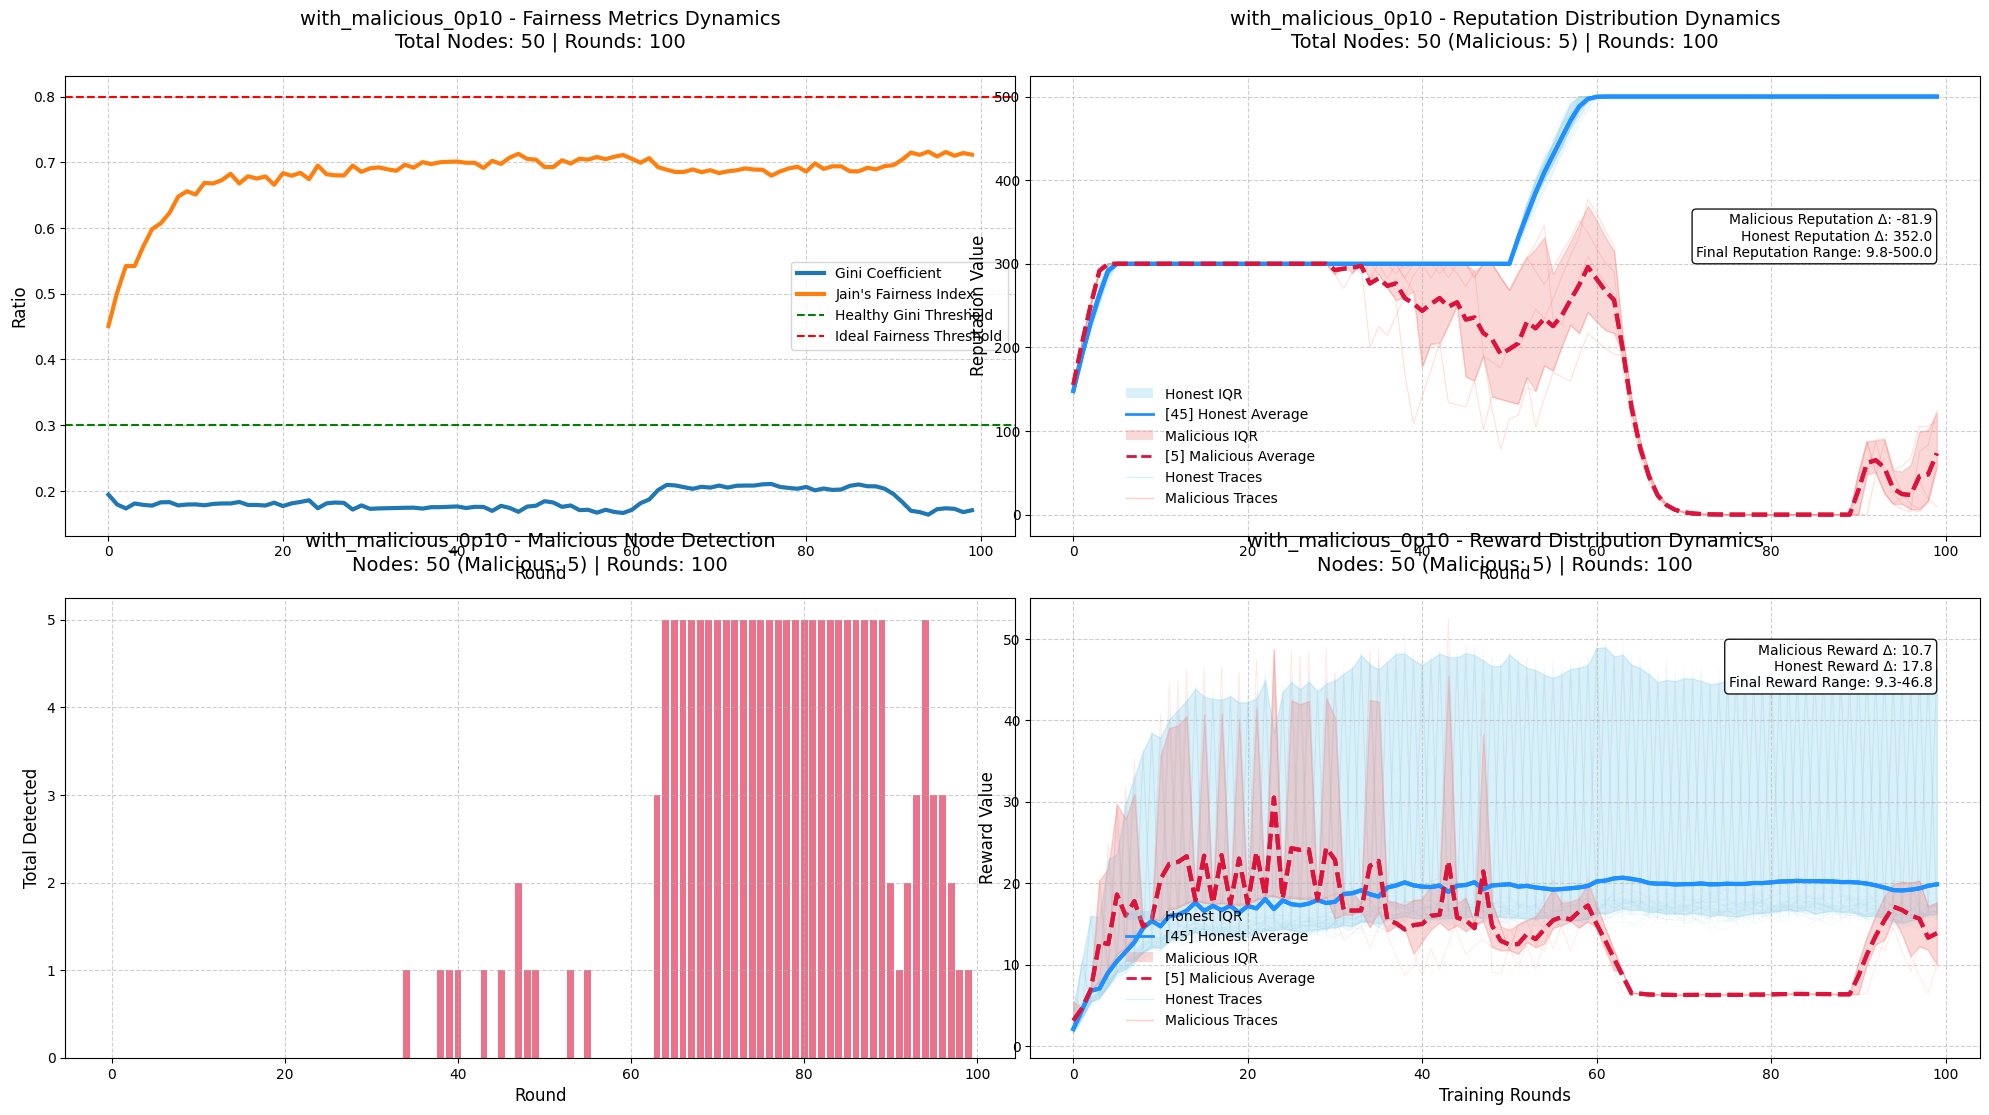

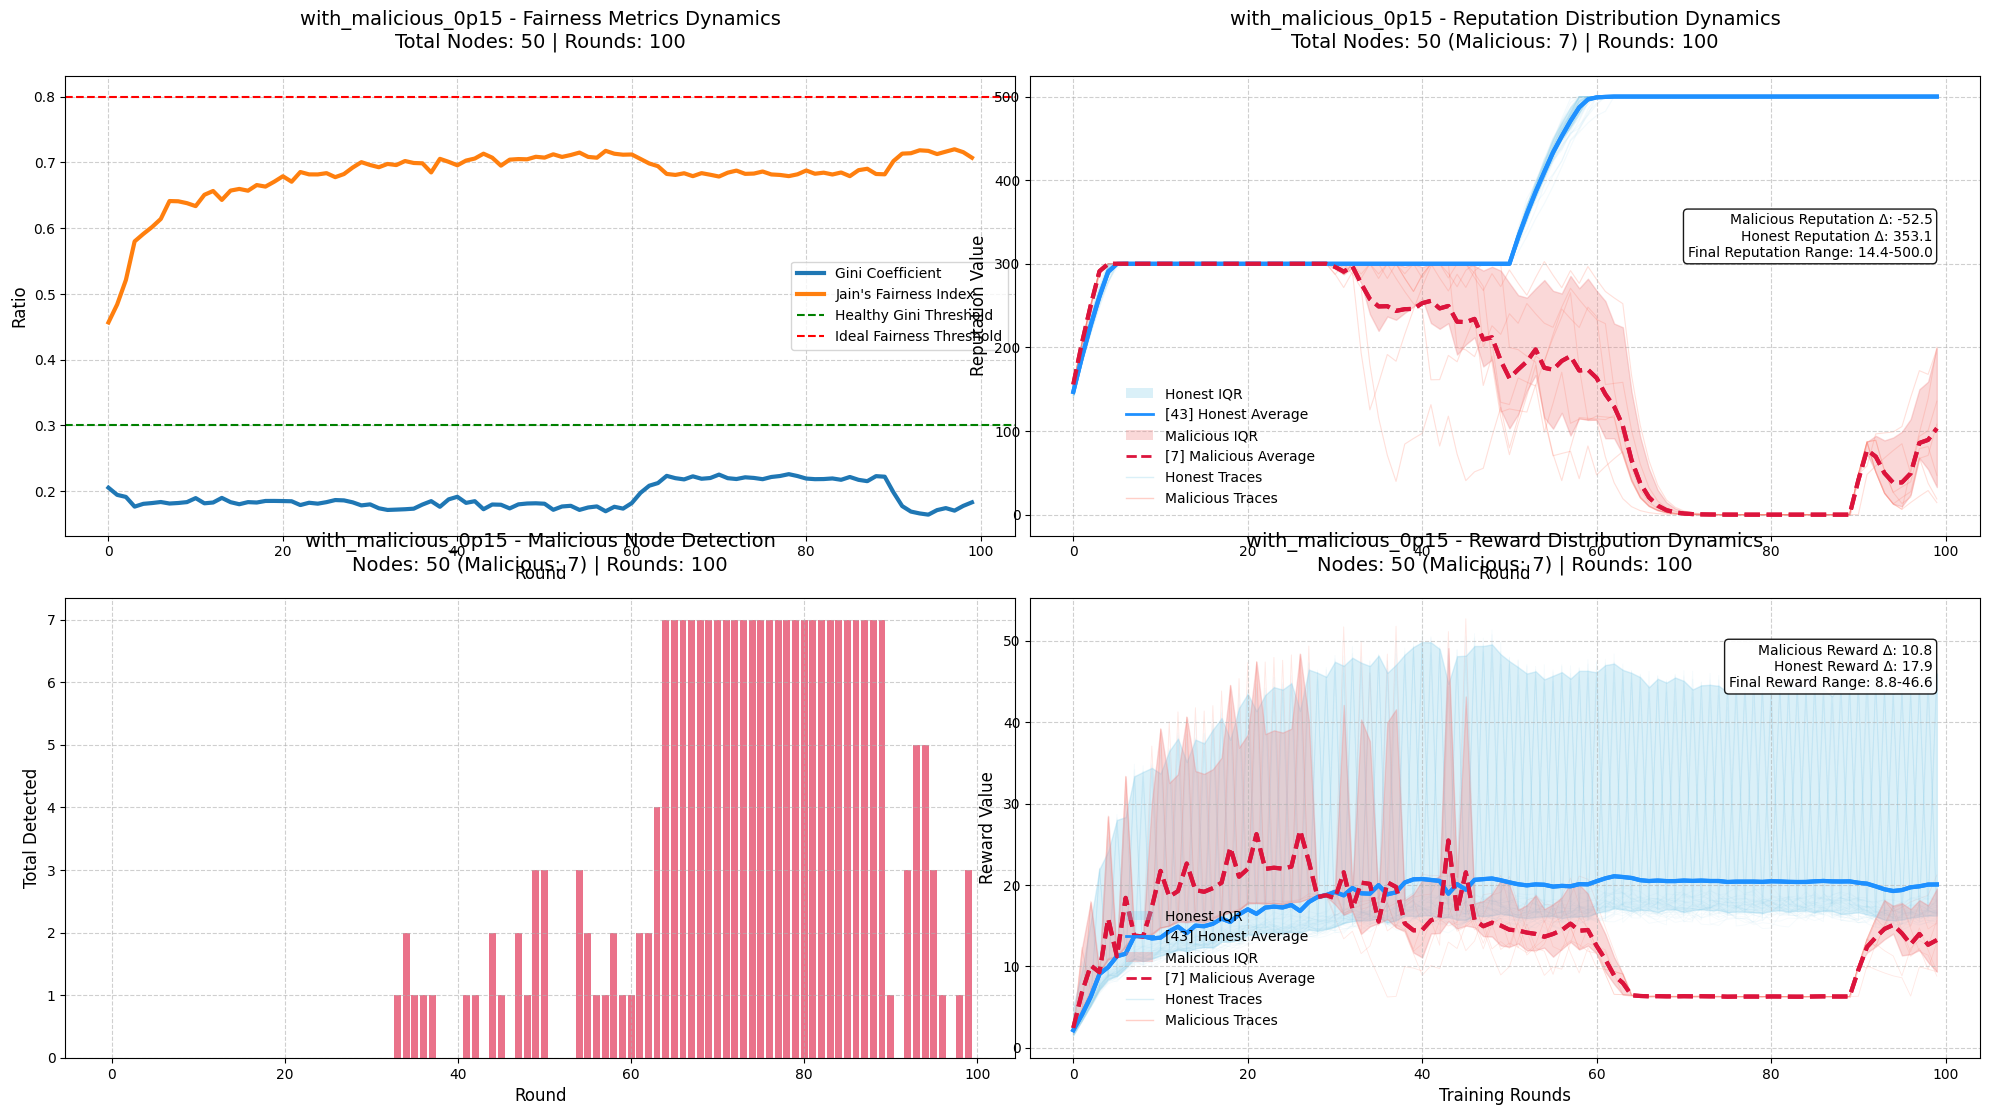

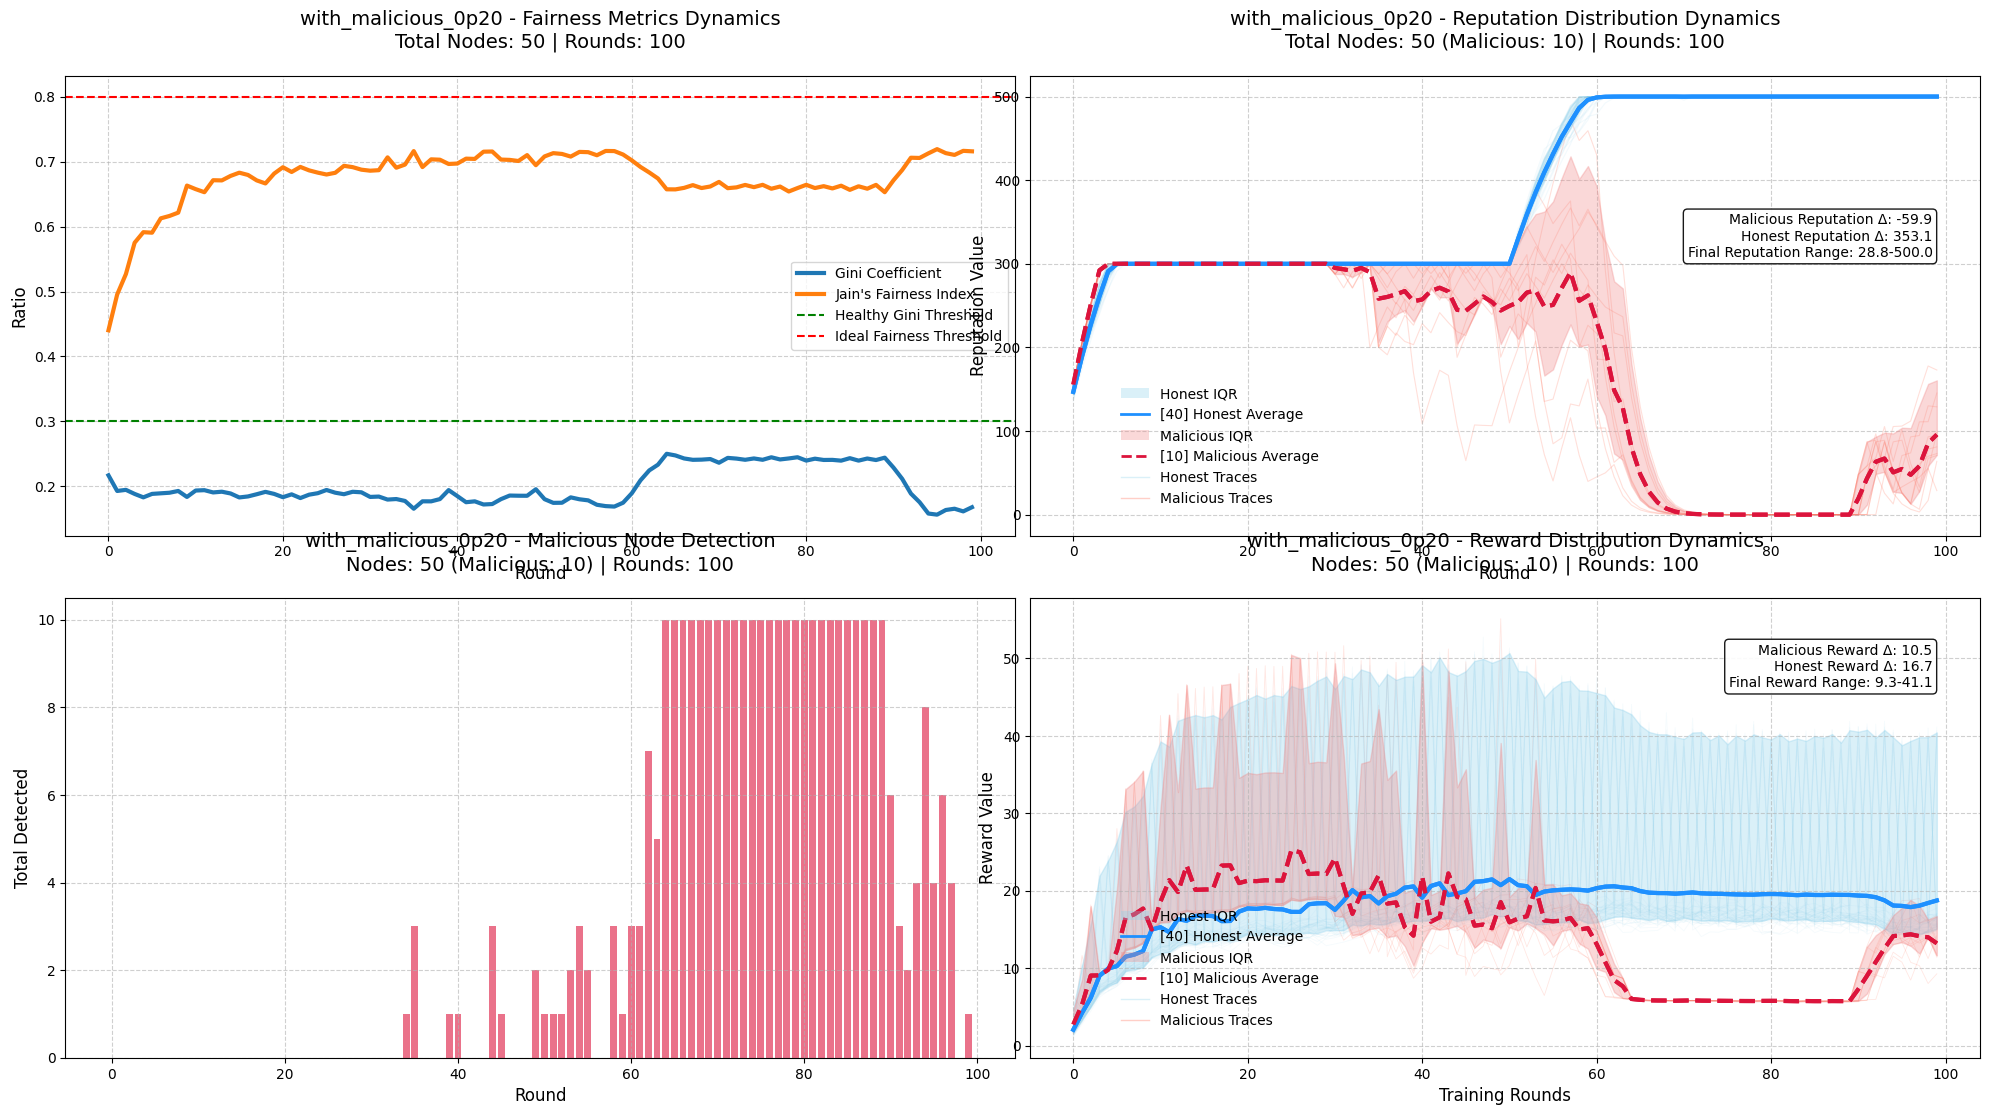

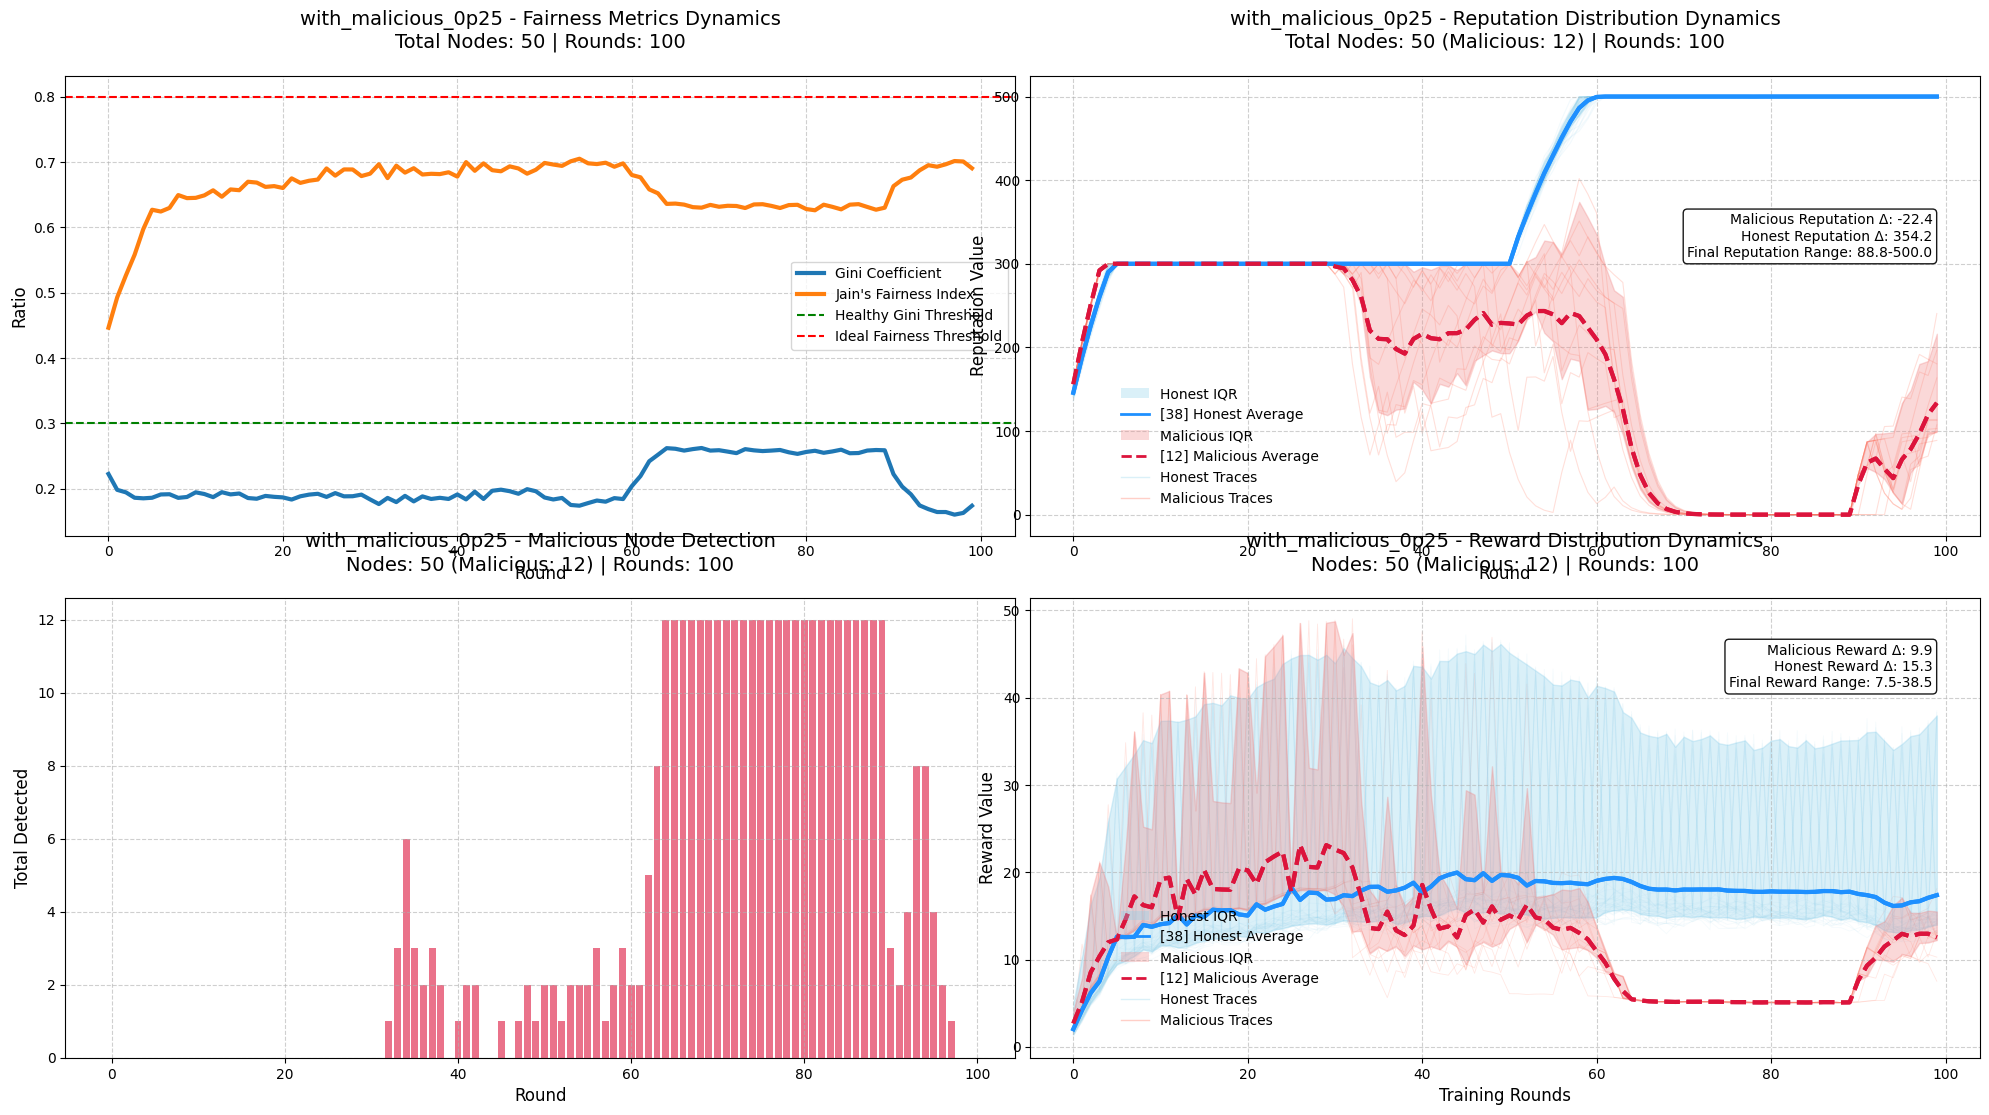

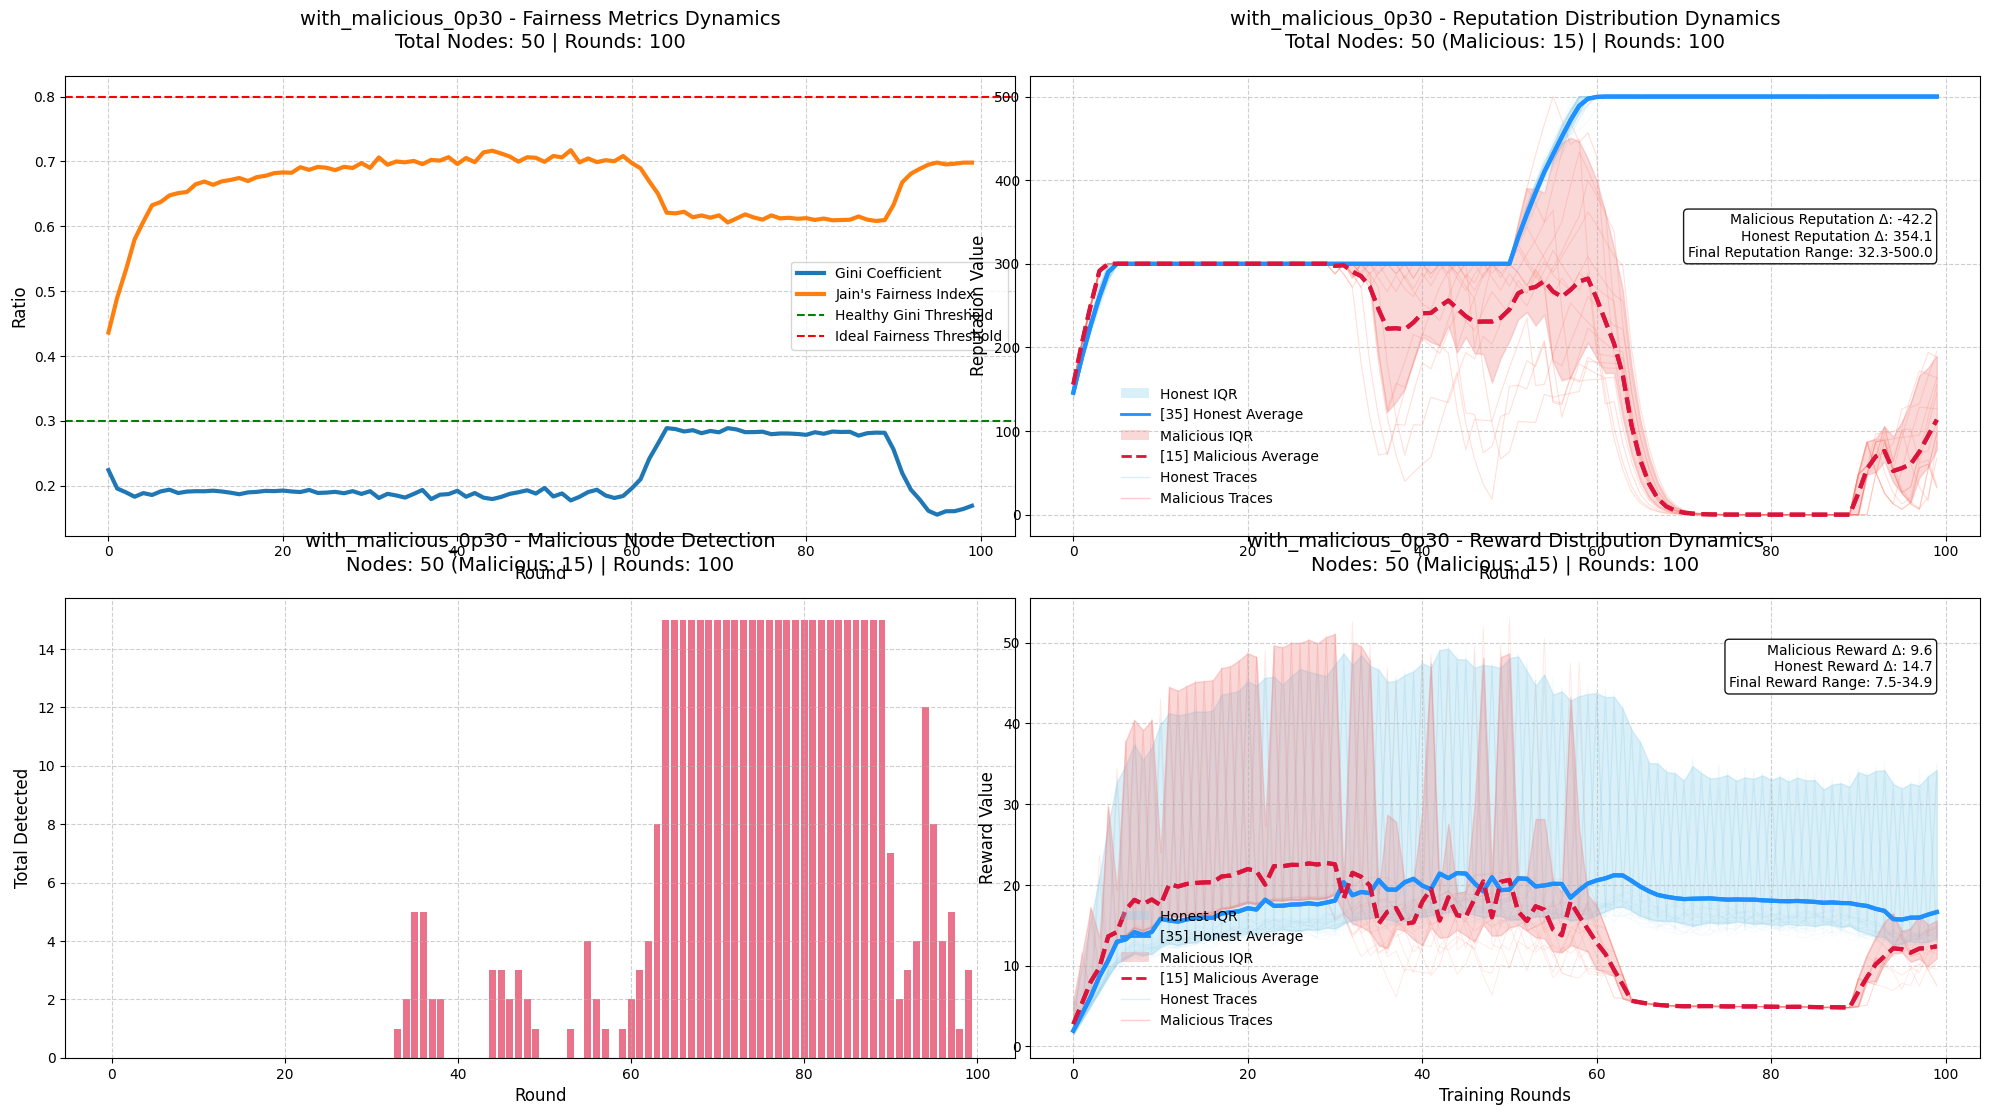

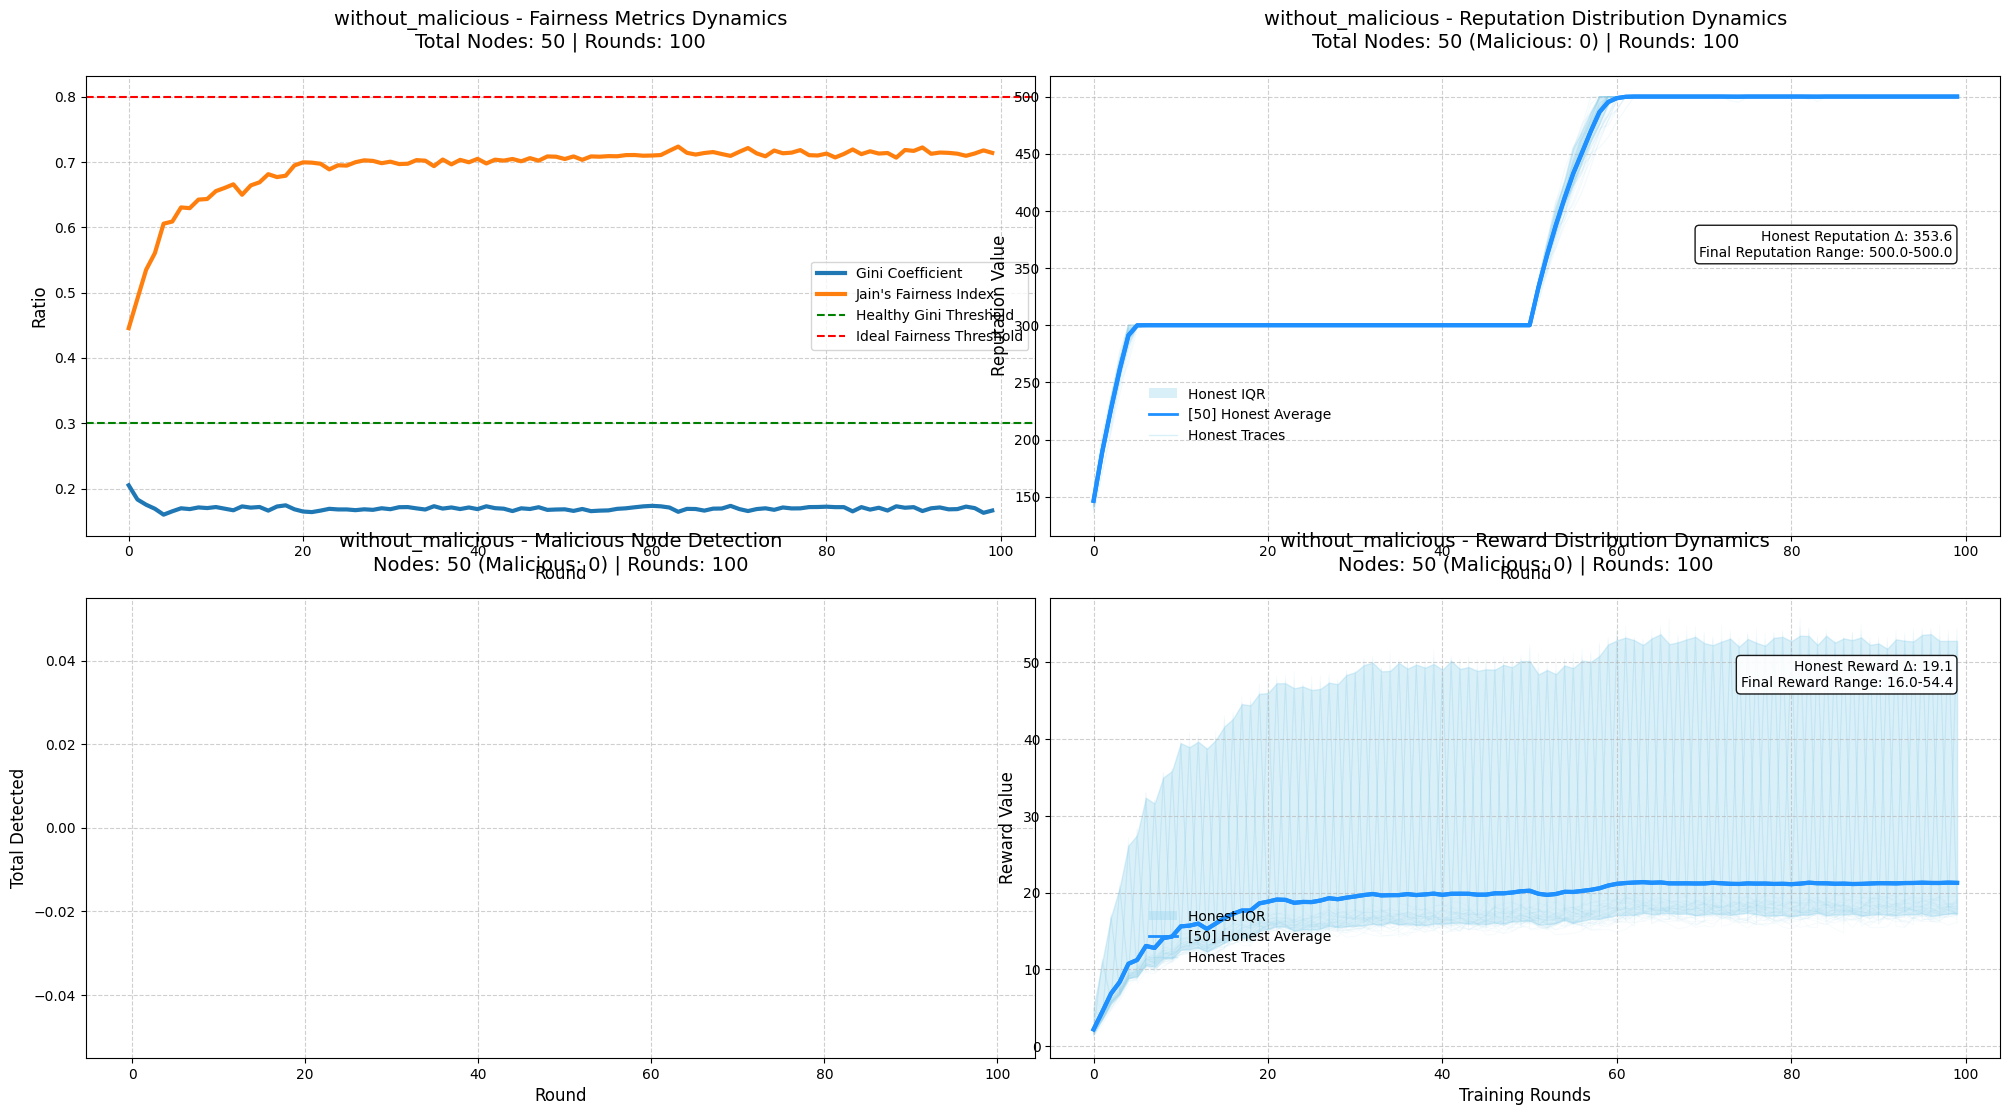

In [4]:

import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import os
import random

# ================== Configure Logging ==================
# logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')
logger = logging.getLogger()

# ================== Utility Functions ==================
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))  # Stability improvement
    return e_x / e_x.sum()

def gini(x):
    """Robust Gini Coefficient Calculation"""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0.0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx)/cumx[-1])/n

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def jain_fairness(x):
    """Improved Jain Index Calculation"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x)**2) / (len(x)*np.sum(x**2) + 1e-8) * sigmoid(np.mean(x)/10)

# ================== Node Class ==================
class Node:
    """Enhanced Federated Learning Node"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake
        self.reputation = init_rep
        self.total_reward = 0
        self.violations = 0
        self.participation = 0
        self.contrib_history = []
        self.cooldown = 0
        self.last_violation_round = -np.inf
        self.consecutive_committee = 0
        self.total_committee = 0  # 已有
        self.committee_count = 0  # 新增：被选为委员会成员的次数
        self.identity_verified = True  # All nodes are verified

    def update_committee_status(self, is_in_committee):
        """Update committee status (including cooldown mechanism)"""
        if is_in_committee and self.cooldown <= 0:
            self.consecutive_committee += 1
            self.total_committee += 1
            self.committee_count += 1  # 累计被选次数
            self.cooldown = 3  # Example cooldown period
            logger.debug(f"Node {self.id} selected for committee. Cooldown set to {self.cooldown}.")
        else:
            if is_in_committee and self.cooldown > 0:
                logger.debug(f"Node {self.id} attempted to join committee but is in cooldown.")
            self.consecutive_committee = 0
        # Decrement cooldown if greater than 0
        if self.cooldown > 0:
            self.cooldown = max(0, self.cooldown - 1)
            logger.debug(f"Node {self.id} cooldown decremented to {self.cooldown}.")

    def act_normal(self):
        """Normal behavior pattern (with random fluctuation)"""
        base = np.random.normal(7, 1)
        fluctuation = np.random.choice([0.8, 1.0, 1.2], p=[0.2, 0.6, 0.2])
        contrib = max(0, base * fluctuation)
        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted normally with contribution {contrib:.2f}.")
        return contrib

    def act_malicious(self, phase):
        """Enhanced robust malicious behavior method"""
        try:
            phase = int(phase)
            if phase == 1:  # High contribution attack
                contrib = max(9.5, np.random.normal(9.8, 0.3))
            elif phase == 2:    # Zero contribution attack
                contrib = 0
            elif phase == 3:    # Random attack (60% high contrib, 40% zero)
                contrib = np.random.choice([10, 0], p=[0.6, 0.4])
            else:
                raise ValueError(f"Invalid attack phase: {phase}")
        except Exception as e:
            logger.error(f"Node {self.id} attack phase error: {str(e)}")
            contrib = 0  # Safe default value

        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted maliciously with contribution {contrib}.")
        return contrib

# ================== FLSystem Class ==================
class FLSystem:
    """Federated Learning System Simulator (Optimized for Stratified Sampling)"""
    def __init__(self, 
                 num_nodes=100,
                 base_reward=1000,
                 committee_size=10,
                 stake_weight=0.4,
                 rep_exponent=0.5,
                 init_stake=100,
                 init_rep=100,
                 malicious_ratio=0.1,
                 phase_switch_round=25,
                 sybil_resistance=False,  # Sybil resistance not needed
                 random_selection_ratio=0.1):  # 新增：随机选择比例
        # Save parameters as instance attributes
        self.sybil_resistance = sybil_resistance  # Not used in selection
        self.random_selection_ratio = random_selection_ratio  # 新增

        # Initialize nodes
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        
        # Initialize malicious nodes
        self.malicious_nodes = self._init_malicious_nodes(malicious_ratio)
        
        # System parameters
        self.base_reward = base_reward
        self.malicious_ratio = malicious_ratio
        self.committee_size = committee_size
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.phase_switch_round = phase_switch_round
        
        # Tracking state
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []
        self.gini_history = []
        self.fairness_history = []
        self.detection_history = []
        self.committee_history = []  # Committee history
        self.penalty_history = []  # Penalty history
        self.committee_fairness_history = []  # 新增：记录每轮的委员会公平性指标

    def _init_malicious_nodes(self, ratio):
        """Initialize malicious nodes (all nodes are verified)"""
        num_malicious = int(len(self.nodes) * ratio)
        if num_malicious > 0:
            malicious = self.nodes[:num_malicious]
            logger.info(f"Initialized {num_malicious} malicious nodes.")
        else:
            malicious = []
            logger.info("No malicious nodes initialized.")
        return malicious  # All malicious nodes are verified

    def _dynamic_malicious_threshold(self):
        """Dynamically calculate the threshold for malicious node detection"""
        # Get the latest contribution values of all nodes
        contribs = []
        for n in self.nodes:
            if n.contrib_history:
                contribs.append(n.contrib_history[-1])
            else:
                contribs.append(0)
        
        # Calculate the 30th percentile and adjust
        percentile_30 = np.percentile(contribs, 30)
        threshold = percentile_30 * 0.7 + 1e-8  # Add a tiny value to prevent division by zero
        logger.debug(f"Dynamic malicious threshold calculated: {threshold:.4f}")
        return threshold

    def calculate_committee_fairness(self):
        """Calculate fairness metrics for committee selection"""
        committee_counts = [node.committee_count for node in self.nodes]
        n = len(self.nodes)
        if n == 0:
            return {"Jain": 1.0, "StdDev": 0.0}
        
        # Calculate standard deviation
        mean_count = np.mean(committee_counts)
        std_dev = np.std(committee_counts)
        
        # Calculate Jain's Fairness Index
        sum_counts = np.sum(committee_counts)
        sum_counts_sq = np.sum(np.square(committee_counts))
        if sum_counts_sq == 0:
            jain_fairness = 1.0
        else:
            jain_fairness = (sum_counts ** 2) / (n * sum_counts_sq + 1e-8)
        
        return {"Jain": jain_fairness, "StdDev": std_dev}

    def select_committee(self, num_strata=3):
        """
        Select committee members using stratified sampling based on reputation and cooldown.

        Parameters:
            num_strata (int): Number of strata to divide the nodes into.

        Returns:
            selected (list): List of selected committee nodes.
        """
        # Sort nodes by reputation descending
        sorted_nodes = sorted(self.nodes, key=lambda x: x.reputation, reverse=True)
        strata_size = len(sorted_nodes) // num_strata
        strata = [sorted_nodes[i*strata_size : (i+1)*strata_size] for i in range(num_strata)]
        
        # Handle any remaining nodes by adding to the last stratum
        if len(sorted_nodes) % num_strata != 0:
            strata[-1].extend(sorted_nodes[num_strata*strata_size:])
            logger.debug(f"Added {len(sorted_nodes) % num_strata} nodes to the last stratum.")

        selected = []
        quotas = [self.committee_size // num_strata] * num_strata  # Initial quota per stratum
        remaining_quota = self.committee_size - sum(quotas)

        # Distribute remaining_quota among the first few strata
        for i in range(remaining_quota):
            quotas[i % num_strata] += 1
        logger.debug(f"Final Quotas per Stratum: {quotas}")

        # First Pass: Select based on strata quotas
        for idx, (stratum, quota) in enumerate(zip(strata, quotas)):
            # Filter eligible candidates (not in cooldown)
            candidates = [node for node in stratum if node.cooldown <= 0]
            eligible_count = len(candidates)
            logger.debug(f"Stratum {idx+1}: {eligible_count} eligible candidates.")

            if eligible_count == 0:
                logger.debug(f"Stratum {idx+1} has no eligible candidates. Quota remains unfilled.")
                continue  # Quota will be redistributed later

            # Determine how many to select from this stratum
            select_count = min(quota, eligible_count)
            select_count = max(1, select_count)  # Ensure at least one selection if possible

            # Calculate selection probabilities based on reputation
            if eligible_count == 1:
                probabilities = [1.0]
            else:
                reputation_scores = np.array([node.reputation for node in candidates], dtype=float)
                probabilities = softmax(reputation_scores ** self.rep_exponent)

            # Select nodes
            selected_nodes = np.random.choice(candidates, size=select_count, p=probabilities, replace=False)
            selected.extend(selected_nodes)
            logger.debug(f"Stratum {idx+1}: Selected {select_count} nodes.")

        # Check if committee size is met
        if len(selected) < self.committee_size:
            logger.debug(f"Committee size after first pass: {len(selected)}. Redistributing remaining quota.")
            remaining_quota = self.committee_size - len(selected)
            
            # Gather all eligible nodes not yet selected
            eligible_nodes = [node for node in self.nodes if node.cooldown <= 0 and node not in selected]
            eligible_count = len(eligible_nodes)
            logger.debug(f"Total eligible nodes for redistribution: {eligible_count}.")

            if eligible_count >= remaining_quota:
                if eligible_count == 1:
                    probabilities = [1.0]
                else:
                    reputation_scores = np.array([node.reputation for node in eligible_nodes], dtype=float)
                    probabilities = softmax(reputation_scores ** self.rep_exponent)
                
                # Select remaining_quota nodes
                selected_nodes = np.random.choice(eligible_nodes, size=remaining_quota, p=probabilities, replace=False)
                selected.extend(selected_nodes)
                logger.debug(f"Redistributed and selected {remaining_quota} additional nodes.")
            elif eligible_count > 0:
                # Select all remaining eligible nodes
                selected.extend(eligible_nodes)
                logger.warning(f"Only {eligible_count} eligible nodes available for redistribution. Committee size reduced.")

        # Final Check
        if len(selected) < self.committee_size:
            logger.warning(f"Unable to fill the committee to the desired size of {self.committee_size}. "
                           f"Only {len(selected)} members selected.")
        else:
            logger.debug(f"Successfully selected {len(selected)} committee members.")

        # Apply random selection ratio for fairness
        num_random = int(self.committee_size * self.random_selection_ratio)
        if num_random > 0:
            eligible_nodes = [node for node in self.nodes if node.cooldown <= 0 and node not in selected]
            eligible_count = len(eligible_nodes)
            logger.debug(f"Random selection: {num_random} nodes to be randomly selected from {eligible_count} eligible nodes.")
            if eligible_count >= num_random:
                random_selected = np.random.choice(eligible_nodes, size=num_random, replace=False)
                selected.extend(random_selected)
                logger.debug(f"Randomly selected {num_random} nodes for committee.")
            elif eligible_count > 0:
                selected.extend(eligible_nodes)
                logger.warning(f"Only {eligible_count} eligible nodes available for random selection.")

        # Ensure committee size
        if len(selected) < self.committee_size:
            remaining_quota = self.committee_size - len(selected)
            eligible_nodes = [node for node in self.nodes if node.cooldown <= 0 and node not in selected]
            if len(eligible_nodes) >= remaining_quota:
                additional_selected = np.random.choice(eligible_nodes, size=remaining_quota, replace=False)
                selected.extend(additional_selected)
                logger.debug(f"Selected {remaining_quota} additional nodes to meet committee size.")
            elif len(eligible_nodes) > 0:
                selected.extend(eligible_nodes)
                logger.warning(f"Only {len(eligible_nodes)} nodes available to meet committee size.")

        # Final Check
        if len(selected) < self.committee_size:
            logger.warning(f"Unable to fill the committee to the desired size of {self.committee_size}. "
                           f"Only {len(selected)} members selected.")
        else:
            logger.debug(f"Successfully selected {len(selected)} committee members.")

        # Update node statuses
        for node in self.nodes:
            node.update_committee_status(node in selected)

        self.committee_history.append([node.id for node in selected])
        logger.info(f"Round {self.current_round + 1}: Committee selected with {len(selected)} members.")

        # Calculate and record committee fairness
        fairness_metrics = self.calculate_committee_fairness()
        self.committee_fairness_history.append(fairness_metrics)
        logger.debug(f"Round {self.current_round + 1}: Committee Fairness - Jain's Index: {fairness_metrics['Jain']:.4f}, StdDev: {fairness_metrics['StdDev']:.4f}")

        return selected

    def calculate_reward(self, node, avg_rep):
        """Dynamic hybrid reward calculation with fairness adjustment"""
        # Effective stake (anti-monopoly)
        avg_stake = np.mean([n.stake for n in self.nodes])
        effective_stake = min(node.stake, avg_stake * 3)

        # Time-decayed contribution
        hist_contrib = sum(c * (0.9**t) for t, c in enumerate(reversed(node.contrib_history[-5:])))

        # Normalize using total time-decayed contributions of all nodes
        total_hist_contrib = sum(
            sum(c * (0.9**t) for t, c in enumerate(reversed(n.contrib_history[-5:])))
            for n in self.nodes
        )
        total_hist_contrib = total_hist_contrib if total_hist_contrib > 0 else 1e-8  # Prevent division by zero

        # Dynamic weights using sigmoid function
        alpha = sigmoid((avg_rep - 100)/50) * self.stake_weight
        beta = 1 - alpha

        # Diversity bonus
        diversity_bonus = 1 - gini([n.reputation for n in self.nodes])

        # Committee reward
        committee_reward = 40 * diversity_bonus if node.id in self.committee_history[-1] else 0

        # Fairness adjustment based on committee fairness
        if self.committee_fairness_history:
            latest_fairness = self.committee_fairness_history[-1]
            jain_fairness = latest_fairness['Jain']
        else:
            jain_fairness = 1.0  # Default to maximum fairness

        fairness_adjustment = jain_fairness  # Scale as needed

        # Total reward calculation with fairness adjustment
        total = (alpha * self.base_reward * (effective_stake / (sum(n.stake for n in self.nodes) + 1e-8)) +
                beta * self.base_reward * (hist_contrib / total_hist_contrib) + committee_reward) * diversity_bonus * fairness_adjustment

        return max(total, 0)

    def update_reputation(self, node, contribution):
        """Enhanced reputation update system with recovery mechanism"""
        # Dynamic decay
        age_factor = 1 - 1/(1 + node.participation/100)
        delta = 0.90 + 0.05 * age_factor  # Increased decay factor for fairness

        # Contribution quality
        contrib_quality = sigmoid((contribution - 5)/3)

        # Stability evaluation
        if len(node.contrib_history) >= 5:
            stability = 1 - np.std(node.contrib_history[-5:])/5
        else:
            stability = 0.8

        # Reputation update with recovery mechanism
        if node.violations == 0 and node.consecutive_committee > 3:
            recovery = 10  # Fixed recovery amount
        else:
            recovery = 0

        new_rep = (node.reputation * delta +
                  contrib_quality * 50 +
                  stability * 30 + recovery)

        # Dynamic cap
        rep_cap = 500 if self.current_round > 50 else 300
        return np.clip(new_rep, 0, rep_cap)

    def detect_malicious(self, node):
        """Hybrid detection strategy"""
        # Basic detection
        if len(node.contrib_history) < 5:
            return False

        window = node.contrib_history[-5:]
        avg = np.mean(window)
        std = np.std(window)
        threshold = self._dynamic_malicious_threshold()

        # Rule 1: Persistent low contributions
        condition1 = avg < threshold * 0.7

        # Rule 2: Abnormal fluctuation
        condition2 = std < threshold * 0.4

        # Rule 3: Sudden behavior change
        if len(node.contrib_history) >= 10:
            prev_avg = np.mean(node.contrib_history[-10:-5])
        else:
            prev_avg = 7  # Default value if not enough history
        condition3 = abs(avg - prev_avg) > 5

        is_malicious = (condition1 and condition2) or condition3
        logger.debug(f"Node {node.id} detection: Condition1={condition1}, Condition2={condition2}, Condition3={condition3} -> {is_malicious}")
        return is_malicious

    def run_round(self):
        """Execute simulation round"""        
        # Improved phase calculation logic
        base_phase = 1 if self.current_round < self.phase_switch_round else 2
        phase_variation = int(self.current_round/30) % 2
        attack_phase = min(base_phase + phase_variation, 3)
        logger.info(f"Round {self.current_round + 1}: Phase {attack_phase}")

        contributions = []  # Initialize contributions list

        # Collect all nodes' contributions
        for node in self.nodes:
            if node in self.malicious_nodes:
                contrib = node.act_malicious(attack_phase)
            else:
                contrib = node.act_normal()
            contributions.append(contrib)  # Add this line

        # Committee selection
        self.committee = self.select_committee()

        # System updates
        avg_rep = np.mean([n.reputation for n in self.nodes])
        rewards = []
        detected = 0
        penalties = []

        for node, contrib in zip(self.nodes, contributions):
            # Detection and penalty
            if self.detect_malicious(node):
                penalty = min(0.3 * node.reputation + 0.1 * node.stake, node.reputation * 0.5)
                penalties.append(penalty)
                node.reputation -= penalty
                node.violations += 1
                detected += 1
                logger.debug(f"Node {node.id} detected as malicious. Penalty applied: {penalty:.2f}")
            else:
                node.reputation = self.update_reputation(node, contrib)
                logger.debug(f"Node {node.id} reputation updated to {node.reputation:.2f}")
            
            # Reward calculation
            reward = self.calculate_reward(node, avg_rep)
            node.total_reward += reward
            rewards.append(reward)
            logger.debug(f"Node {node.id} received reward: {reward:.2f} | Total Reward: {node.total_reward:.2f}")
            
            node.participation += 1

        # Record metrics
        self.penalty_history.append(penalties)
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.gini_history.append(gini(rewards))
        self.fairness_history.append(jain_fairness(rewards))
        self.detection_history.append(detected)
        self.current_round += 1
        logger.info(f"Round {self.current_round}: Detected {detected} malicious nodes.")

        # Record committee fairness metrics (already done in select_committee)
    
# ================== Visualization Module ==================
def plot_metrics(system, label="System"):
    """System-Wide Metrics Visualization"""
    
    plt.figure(figsize=(20, 16))  # 调整图表大小

    # ---------- Fairness metrics for Rewards -------------
    plt.subplot(3, 2, 1)
    rewards = np.array(system.reward_history)
    rounds = np.arange(rewards.shape[0])
    num_nodes = rewards.shape[1]

    plt.plot(system.gini_history, linewidth=3, label='Gini Coefficient')
    plt.plot(system.fairness_history, linewidth=3, label="Jain's Fairness Index")
    plt.axhline(0.3, color='green', linestyle='--', label='Healthy Gini Threshold')
    plt.axhline(0.8, color='red', linestyle='--', label='Ideal Fairness Threshold')
    plt.title(f'{label} - Fairness Metrics Dynamics\nTotal Nodes: {num_nodes} | Rounds: {len(rounds)}', 
             fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()
    plt.tight_layout()

    # --------- Fairness metrics for Committee Selection -----------
    # plt.subplot(3, 2, 2)
    # if not system.committee_fairness_history:
    #     print("警告：无委员会公平性数据可供可视化")
    #     plt.title('委员会公平性数据未找到')
    # else:
    #     jain_fairness = [fm['Jain'] for fm in system.committee_fairness_history]
    #     std_dev = [fm['StdDev'] for fm in system.committee_fairness_history]
        
    #     plt.plot(jain_fairness, linewidth=3, label="Jain's Fairness Index", color='purple')
    #     plt.plot(std_dev, linewidth=3, label="Standard Deviation", color='orange')
    #     plt.title(f'{label} - Committee Selection Fairness Dynamics\nTotal Nodes: {num_nodes} | Rounds: {len(rounds)}', 
    #              fontsize=14, pad=20)
    #     plt.xlabel('Round', fontsize=12)
    #     plt.ylabel('Fairness Metric', fontsize=12)
    #     plt.grid(True, linestyle='--', alpha=0.6)
    #     plt.legend()
    #     plt.tight_layout()

    # --------- Reputation Distribution -----------
    plt.subplot(3, 2, 2)
    if not system.reputation_history:
        print("警告：无声誉数据可供可视化")
        plt.title('声誉数据未找到')
    else:
        reps = np.array(system.reputation_history)
        rounds = np.arange(reps.shape[0])
        num_nodes = reps.shape[1]
        
        # Identify malicious nodes
        malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
        honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
        
        # Plot individual traces with group coloring
        for node_id in range(num_nodes):
            color = 'tomato' if node_id in malicious_ids else 'skyblue'
            alpha = 0.2 if node_id in malicious_ids else 0.1
            plt.plot(rounds, reps[:, node_id], 
                    color=color, 
                    alpha=alpha, 
                    linewidth=0.8,
                    zorder=1)
        
        # Calculate group averages
        if malicious_ids:
            malicious_avg = np.mean(reps[:, malicious_ids], axis=1)
            malicious_q1 = np.percentile(reps[:, malicious_ids], 25, axis=1)
            malicious_q3 = np.percentile(reps[:, malicious_ids], 95, axis=1)
        else:
            malicious_avg = np.array([])
            malicious_q1 = np.array([])
            malicious_q3 = np.array([])
        
        honest_avg = np.mean(reps[:, honest_ids], axis=1)
        honest_q1 = np.percentile(reps[:, honest_ids], 25, axis=1)
        honest_q3 = np.percentile(reps[:, honest_ids], 95, axis=1)
        
        # Plot group averages
        plt.plot(rounds, honest_avg, 
                color='dodgerblue', 
                linewidth=3, 
                linestyle='-',
                label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
                zorder=4)
        
        if len(malicious_avg) > 0:
            plt.plot(rounds, malicious_avg, 
                    color='crimson', 
                    linewidth=3, 
                    linestyle='--',
                    label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                    zorder=5)

        # Plot group statistics
        plt.fill_between(rounds, honest_q1, honest_q3,
                        color='skyblue', alpha=0.3,
                        label='Honest IQR', zorder=2)
        plt.plot(rounds, honest_avg,
                color='dodgerblue', lw=3,
                label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
        
        # Plot malicious nodes statistics (if any)
        if len(malicious_avg) > 0:
            plt.fill_between(rounds, malicious_q1, malicious_q3,
                            color='lightcoral', alpha=0.3,
                            label='Malicious IQR', zorder=2)
            plt.plot(rounds, malicious_avg,
                    color='crimson', lw=3, linestyle='--',
                    label=f'[{len(malicious_ids)}] Malicious Avg (μ={malicious_avg[-1]:.1f})')

        # Formatting
        plt.title(f'{label} - Reputation Distribution Dynamics\n'
                 f'Total Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}', 
                 fontsize=14, pad=20)
        plt.xlabel('Round', fontsize=12)
        plt.ylabel('Reputation Value', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # Create layered legend
        legend_elements = [
            Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
            Line2D([0], [0], color='dodgerblue', lw=2, label=f'[{len(honest_ids)}] Honest Average'),
        ]
        
        if len(malicious_avg) > 0:
            legend_elements.extend([
                Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
                Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'[{len(malicious_ids)}] Malicious Average'),
            ])
        
        legend_elements.extend([
            Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
        ])
        
        if len(malicious_avg) > 0:
            legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
        
        plt.legend(handles=legend_elements, 
                  loc='upper center',
                  bbox_to_anchor=(0.2, 0.35),  
                  ncol=1,
                  frameon=False,
                  fontsize=10)
        
        # Add dynamic statistical annotations
        stats_text = []
        if len(malicious_avg) > 0:
            stats_text.append(f"Malicious Reputation Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
        stats_text.extend([
            f"Honest Reputation Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
            f"Final Reputation Range: {np.min(reps[-1]):.1f}-{np.max(reps[-1]):.1f}",
        ])
        
        plt.annotate('\n'.join(stats_text), 
                    xy=(0.95, 0.6),
                    xycoords='axes fraction',
                    ha='right',
                    va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))

    # --------- Committee Fairness Metrics -----------
    # plt.subplot(3, 2, 4)
    # if not system.committee_fairness_history:
    #     print("警告：无委员会公平性数据可供可视化")
    #     plt.title('委员会公平性数据未找到')
    # else:
    #     jain_fairness = [fm['Jain'] for fm in system.committee_fairness_history]
    #     std_dev = [fm['StdDev'] for fm in system.committee_fairness_history]
        
    #     plt.plot(jain_fairness, linewidth=3, label="Jain's Fairness Index", color='purple')
    #     plt.plot(std_dev, linewidth=3, label="Standard Deviation", color='orange')
    #     plt.title(f'{label} - Committee Selection Fairness Metrics\nTotal Nodes: {num_nodes} | Rounds: {len(rounds)}', 
    #              fontsize=14, pad=20)
    #     plt.xlabel('Round', fontsize=12)
    #     plt.ylabel('Fairness Metric', fontsize=12)
    #     plt.grid(True, linestyle='--', alpha=0.6)
    #     plt.legend()
    #     plt.tight_layout()

    # --------- Security Detection ------------
    plt.subplot(3, 2, 3)
    if system.detection_history:
        plt.bar(range(len(system.detection_history)), system.detection_history, alpha=0.6, color='crimson')
        plt.title(f'{label} - Malicious Node Detection\n'
                  f'Nodes: {num_nodes} (Malicious: {len(system.malicious_nodes)}) | Rounds: {len(rounds)}',
                  fontsize=14, pad=20)
        plt.xlabel('Round', fontsize=12)
        plt.ylabel('Total Detected', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
    else:
        plt.title('Security Detection Data Not Available')

    # -------- Reward Distribution ------------
    plt.subplot(3, 2, 4)
    """Dynamic reward distribution visualization (including malicious/honest node distinction)"""
    if not system.reward_history:
        print("警告：无奖励数据可供可视化")
        plt.title('奖励数据未找到')
    else:
        # Data preparation
        rewards = np.array(system.reward_history)
        rounds = np.arange(rewards.shape[0])
        num_nodes = rewards.shape[1]
        
        # Identify malicious nodes
        malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
        honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
        
        # Plot individual reward traces with group coloring
        for node_id in range(num_nodes):
            color = 'tomato' if node_id in malicious_ids else 'skyblue'
            alpha = 0.15 if node_id in malicious_ids else 0.08
            plt.plot(rounds, rewards[:, node_id], 
                    color=color, 
                    alpha=alpha, 
                    linewidth=0.6,
                    zorder=1)
        
        # Calculate group averages
        if malicious_ids:
            malicious_avg = np.mean(rewards[:, malicious_ids], axis=1)
            malicious_q1 = np.percentile(rewards[:, malicious_ids], 25, axis=1)
            malicious_q3 = np.percentile(rewards[:, malicious_ids], 95, axis=1)
        else:
            malicious_avg = np.array([])
            malicious_q1 = np.array([])
            malicious_q3 = np.array([])
        
        honest_avg = np.mean(rewards[:, honest_ids], axis=1)
        honest_q1 = np.percentile(rewards[:, honest_ids], 25, axis=1)
        honest_q3 = np.percentile(rewards[:, honest_ids], 95, axis=1)
        
        # Plot group averages
        plt.plot(rounds, honest_avg, 
                color='dodgerblue', 
                linewidth=3, 
                linestyle='-',
                label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
                zorder=4)
        
        if len(malicious_avg) > 0:
            plt.plot(rounds, malicious_avg, 
                    color='crimson', 
                    linewidth=3, 
                    linestyle='--',
                    label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                    zorder=5)

        # Plot group statistics
        plt.fill_between(rounds, honest_q1, honest_q3,
                        color='skyblue', alpha=0.3,
                        label='Honest IQR')
        plt.plot(rounds, honest_avg,
                color='dodgerblue', lw=3,
                label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
        
        # Plot malicious nodes statistics (if any)
        if len(malicious_avg) > 0:
            plt.fill_between(rounds, malicious_q1, malicious_q3,
                            color='lightcoral', alpha=0.3,
                            label='Malicious IQR')
            plt.plot(rounds, malicious_avg,
                    color='crimson', lw=3, linestyle='--',
                    label=f'[{len(malicious_ids)}] Malicious Avg (μ={malicious_avg[-1]:.1f})')

        # Formatting
        plt.title(f'{label} - Reward Distribution Dynamics\n'
                 f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
                 fontsize=14, pad=20)
        plt.xlabel('Training Rounds', fontsize=12)
        plt.ylabel('Reward Value', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # Create layered legend
        legend_elements = [
            Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
            Line2D([0], [0], color='dodgerblue', lw=2, label=f'[{len(honest_ids)}] Honest Average'),
        ]
        
        if len(malicious_avg) > 0:
            legend_elements.extend([
                Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
                Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'[{len(malicious_ids)}] Malicious Average'),
            ])
        
        legend_elements.extend([
            Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
        ])
        
        if len(malicious_avg) > 0:
            legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
        
        plt.legend(handles=legend_elements,
                  loc='upper center',
                  bbox_to_anchor=(0.2, 0.35),
                  ncol=1,
                  frameon=False,
                  fontsize=10)
        
        # Add dynamic statistical annotations
        stats_text = []
        if len(malicious_avg) > 0:
            stats_text.append(f"Malicious Reward Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
        stats_text.extend([
            f"Honest Reward Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
            f"Final Reward Range: {np.min(rewards[-1]):.1f}-{np.max(rewards[-1]):.1f}",
        ])
        
        plt.annotate('\n'.join(stats_text), 
                    xy=(0.95, 0.8),
                    xycoords='axes fraction',
                    ha='right',
                    va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))
    
# =================== Simulation Report =====================
def generate_simulation_report(system, filename):
    """
    Generates simulation reports for an FLSystem instance and saves them as CSV files.

    Parameters:
        system (FLSystem): The federated learning system instance containing simulation data.
        filename (str): The base filename for the generated reports. The function will create
                        two CSV files with suffixes '_round_metrics.csv' and '_node_summary.csv'.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
                (round_metrics_df, node_summary_df)
    """
    # Validate the filename extension
    if not filename.lower().endswith('.csv'):
        raise ValueError("Filename must end with '.csv'")
    
    # Derive base name without extension
    base, ext = os.path.splitext(filename)
    
    # Define filenames for round metrics and node summary
    round_metrics_filename = f"{base}_round_metrics.csv"
    node_summary_filename = f"{base}_node_summary.csv"
    
    # ------------------ Extract Per-Round Metrics ------------------
    rounds = list(range(1, system.current_round + 1))
    gini_vals = system.gini_history
    fairness = system.fairness_history
    detected = system.detection_history
    penalties = system.penalty_history  # List of lists
    committee_history = system.committee_history  # List of lists
    committee_fairness = system.committee_fairness_history  # 新增

    # Calculate total penalties per round
    total_penalties = [sum(penalty_round) for penalty_round in penalties]
    
    # Format committee members as comma-separated strings
    committee_members = [', '.join(map(str, committee)) for committee in committee_history]
    
    # Calculate committee fairness metrics per round
    jain_committee_fairness = [fm['Jain'] for fm in committee_fairness]
    std_dev = [fm['StdDev'] for fm in committee_fairness]
    
    # Create a DataFrame for per-round metrics
    round_metrics_df = pd.DataFrame({
        'Round': rounds,
        'Gini Coefficient': gini_vals,
        'Fairness Index': fairness,
        'Detected Malicious Nodes': detected,
        'Total Penalties': total_penalties,
        'Committee Members': committee_members,
        "Committee Jain's Fairness": jain_committee_fairness,
        "Committee Selection StdDev": std_dev
    })
    
    # ------------------ Extract Per-Node Summary Metrics ------------------
    node_ids = [node.id for node in system.nodes]
    stakes = [node.stake for node in system.nodes]
    final_reputations = [node.reputation for node in system.nodes]
    total_rewards = [node.total_reward for node in system.nodes]
    violations = [node.violations for node in system.nodes]
    participation = [node.participation for node in system.nodes]
    total_committee = [node.total_committee for node in system.nodes]
    committee_counts = [node.committee_count for node in system.nodes]
    cooldowns = [node.cooldown for node in system.nodes]
    
    # Create a DataFrame for per-node summary
    node_summary_df = pd.DataFrame({
        'Node ID': node_ids,
        'Stake': stakes,
        'Final Reputation': final_reputations,
        'Total Reward': total_rewards,
        'Violations': violations,
        'Participation Count': participation,
        'Total Committee Memberships': total_committee,
        'Committee Selection Count': committee_counts,
        'Current Cooldown': cooldowns
    })
    
    # ------------------ Save DataFrames to CSV Files ------------------
    try:
        # Save round metrics
        round_metrics_df.to_csv(round_metrics_filename, index=False)
        print(f"Round metrics saved to {round_metrics_filename}")
        
        # Save node summary
        node_summary_df.to_csv(node_summary_filename, index=False)
        print(f"Node summary metrics saved to {node_summary_filename}")
        
    except Exception as e:
        print(f"Error saving simulation reports: {e}")
        raise e
    
    # ------------------ Return DataFrames ------------------
    return round_metrics_df, node_summary_df

# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    random.seed(1411758002)
    
    # Initialize FL Systems with different malicious ratios
    systems = {
        "with_malicious_0p10": FLSystem(
            num_nodes=50,
            base_reward=1000,
            committee_size=5,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.1,  # 10% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False,  # Sybil resistance not considered
            random_selection_ratio=0.1  # 10% random selection
        ),
        "with_malicious_0p15": FLSystem(
            num_nodes=50,
            base_reward=1000,
            committee_size=5,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False,  # Sybil resistance not considered
            random_selection_ratio=0.1
        ),
        "with_malicious_0p20": FLSystem(
            num_nodes=50,
            base_reward=1000,
            committee_size=5,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.2,  # 20% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False,  # Sybil resistance not considered
            random_selection_ratio=0.1
        ),
        "with_malicious_0p25": FLSystem(
            num_nodes=50,
            base_reward=1000,
            committee_size=5,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.25,  # 25% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False,  # Sybil resistance not considered
            random_selection_ratio=0.1
        ),
        "with_malicious_0p30": FLSystem(
            num_nodes=50,
            base_reward=1000,
            committee_size=5,  # Desired committee size
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.3,  # 30% malicious nodes
            phase_switch_round=30,
            sybil_resistance=False,  # Sybil resistance not considered
            random_selection_ratio=0.1
        ),
        "without_malicious": FLSystem(
            num_nodes=50,
            base_reward=1000,
            committee_size=5,
            stake_weight=0.4,
            rep_exponent=0.5,
            malicious_ratio=0.0,  # No malicious nodes
            phase_switch_round=30,
            sybil_resistance=False,
            random_selection_ratio=0.1
        )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = 100
    rounds_without_malicious = 100

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    print("\n开始运行不包含恶意节点的模拟...")
    for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
        systems["without_malicious"].run_round()
    
    # Generate Reports
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"simulation_report_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=5):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=5)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(f"生成系统 '{key}' 的图表...")
        label = key  # 可以根据需要调整标签显示
        plot_metrics(systems[key], label=label)
    
    print("\n所有模拟和报告生成完毕。")
